# dAiv AI_Competition[2024]_Basic Baseline for PyTorch

## Import Libraries

In [1]:
from os import path, mkdir

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [2]:
!nvidia-smi

Wed Aug  7 10:24:44 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |   5661MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 6

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [4]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [5]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (512, 512)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [6]:
DATA_ROOT = path.join(".", "data")

train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(9866), Valid(3430), Test(3347)


## Data Augmentation if needed

In [7]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [8]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer
])

In [9]:
train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(9866)


## DataLoader

In [10]:
# Set Batch Size
BATCH_SIZE = 64

In [14]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


## Define Model

In [15]:
class ImageClassifier(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, img_size: int, num_classes: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//4, out_channels=output_channel//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//2, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Assuming you want to connect to a fully connected layer after flattening
        # Calculate the size of the flattened features after 3 pooling layers
        self.fc_size = output_channel * (img_size // 2**3) * (img_size // 2**3)
        self.fc = nn.Linear(self.fc_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

In [16]:
CLASS_LABELS = len(train_dataset.classes)

MODEL_PARAMS = dict(
    input_channel=3, output_channel=64,
    img_size=IMG_SIZE[0], num_classes=CLASS_LABELS
)

In [17]:
# Initialize Model
model = ImageClassifier(**MODEL_PARAMS)
model.to(device)

ImageClassifier(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=262144, out_features=11, bias=True)
)

In [18]:
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

## Training Loop

In [19]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [20]:
# Set Epoch Count
num_epochs = 50

Running Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/155 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Output()

Epoch [ 1/50], Step [155/155], Loss: 2.128005, Valid Acc: 30.320695%, Valid Loss: 2.010871

Epoch [ 2/50], Step [155/155], Loss: 1.856637, Valid Acc: 32.886294%, Valid Loss: 1.909602

Epoch [ 3/50], Step [155/155], Loss: 2.071560, Valid Acc: 33.411080%, Valid Loss: 1.929141

Epoch [ 4/50], Step [155/155], Loss: 1.985378, Valid Acc: 35.801744%, Valid Loss: 1.842215

Epoch [ 5/50], Step [155/155], Loss: 2.075855, Valid Acc: 33.935860%, Valid Loss: 1.912544


Epoch [ 6/50], Step [155/155], Loss: 1.562673, Valid Acc: 37.259471%, Valid Loss: 1.799864

Epoch [ 7/50], Step [155/155], Loss: 1.827268, Valid Acc: 35.685125%, Valid Loss: 1.789798

Epoch [ 8/50], Step [155/155], Loss: 1.619666, Valid Acc: 39.271137%, Valid Loss: 1.776347

Epoch [ 9/50], Step [155/155], Loss: 1.612285, Valid Acc: 39.999995%, Valid Loss: 1.711745

Epoch [10/50], Step [155/155], Loss: 0.986971, Valid Acc: 39.008749%, Valid Loss: 1.764285


Epoch [11/50], Step [155/155], Loss: 2.286713, Valid Acc: 40.320697%, Valid Loss: 1.713475

Epoch [12/50], Step [155/155], Loss: 1.953218, Valid Acc: 43.090376%, Valid Loss: 1.665523

Epoch [13/50], Step [155/155], Loss: 1.850574, Valid Acc: 43.119541%, Valid Loss: 1.673238

Epoch [14/50], Step [155/155], Loss: 1.878386, Valid Acc: 41.137028%, Valid Loss: 1.734258

Epoch [15/50], Step [155/155], Loss: 1.680993, Valid Acc: 43.760929%, Valid Loss: 1.628492


Epoch [16/50], Step [155/155], Loss: 2.122666, Valid Acc: 45.102036%, Valid Loss: 1.613396

Epoch [17/50], Step [155/155], Loss: 1.348485, Valid Acc: 45.160353%, Valid Loss: 1.619693

Epoch [18/50], Step [155/155], Loss: 1.499268, Valid Acc: 43.440232%, Valid Loss: 1.689057

Epoch [19/50], Step [155/155], Loss: 1.172191, Valid Acc: 46.413988%, Valid Loss: 1.578548

Epoch [20/50], Step [155/155], Loss: 2.368573, Valid Acc: 47.551018%, Valid Loss: 1.550694


Epoch [21/50], Step [155/155], Loss: 1.032265, Valid Acc: 42.798829%, Valid Loss: 1.664994

Epoch [22/50], Step [155/155], Loss: 1.331875, Valid Acc: 45.510203%, Valid Loss: 1.600372

Epoch [23/50], Step [155/155], Loss: 1.966283, Valid Acc: 48.046640%, Valid Loss: 1.536450

Epoch [24/50], Step [155/155], Loss: 0.789582, Valid Acc: 47.113705%, Valid Loss: 1.524575

Epoch [25/50], Step [155/155], Loss: 2.047482, Valid Acc: 49.737611%, Valid Loss: 1.498808


Epoch [26/50], Step [155/155], Loss: 0.945413, Valid Acc: 48.600578%, Valid Loss: 1.516928

Epoch [27/50], Step [155/155], Loss: 1.552733, Valid Acc: 50.408161%, Valid Loss: 1.479290

Epoch [28/50], Step [155/155], Loss: 1.027659, Valid Acc: 49.329436%, Valid Loss: 1.505233

Epoch [29/50], Step [155/155], Loss: 1.379248, Valid Acc: 50.262386%, Valid Loss: 1.472763

Epoch [30/50], Step [155/155], Loss: 1.078267, Valid Acc: 48.046640%, Valid Loss: 1.530062


Epoch [31/50], Step [155/155], Loss: 1.457725, Valid Acc: 46.705538%, Valid Loss: 1.575169

Epoch [32/50], Step [155/155], Loss: 1.478946, Valid Acc: 50.233221%, Valid Loss: 1.490663

Epoch [33/50], Step [155/155], Loss: 1.511476, Valid Acc: 52.128273%, Valid Loss: 1.437710

Epoch [34/50], Step [155/155], Loss: 1.386190, Valid Acc: 51.865882%, Valid Loss: 1.439393

Epoch [35/50], Step [155/155], Loss: 0.873479, Valid Acc: 53.032058%, Valid Loss: 1.410447


Epoch [36/50], Step [155/155], Loss: 1.588327, Valid Acc: 51.603490%, Valid Loss: 1.426432

Epoch [37/50], Step [155/155], Loss: 1.121120, Valid Acc: 50.728858%, Valid Loss: 1.453902

Epoch [38/50], Step [155/155], Loss: 1.341439, Valid Acc: 52.419817%, Valid Loss: 1.447580

Epoch [39/50], Step [155/155], Loss: 1.831762, Valid Acc: 49.446052%, Valid Loss: 1.460623

Epoch [40/50], Step [155/155], Loss: 0.930015, Valid Acc: 52.857149%, Valid Loss: 1.427129


Epoch [41/50], Step [155/155], Loss: 1.167616, Valid Acc: 49.154511%, Valid Loss: 1.527944

Epoch [42/50], Step [155/155], Loss: 1.650414, Valid Acc: 52.682215%, Valid Loss: 1.423902

Epoch [43/50], Step [155/155], Loss: 1.756716, Valid Acc: 53.265303%, Valid Loss: 1.379361

Epoch [44/50], Step [155/155], Loss: 1.560482, Valid Acc: 52.857137%, Valid Loss: 1.417828

Epoch [45/50], Step [155/155], Loss: 1.556033, Valid Acc: 53.236145%, Valid Loss: 1.397101


Epoch [46/50], Step [155/155], Loss: 0.851220, Valid Acc: 51.311946%, Valid Loss: 1.432195

Epoch [47/50], Step [155/155], Loss: 1.478615, Valid Acc: 53.381920%, Valid Loss: 1.415590

Epoch [48/50], Step [155/155], Loss: 1.677840, Valid Acc: 52.682221%, Valid Loss: 1.412623

Epoch [49/50], Step [155/155], Loss: 1.084829, Valid Acc: 49.329442%, Valid Loss: 1.537194

Epoch [50/50], Step [155/155], Loss: 1.535083, Valid Acc: 53.177840%, Valid Loss: 1.397972


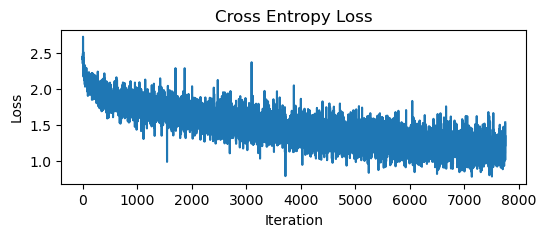

In [22]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            update(loss)
            train_progress.update(1)

        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)

        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")

In [23]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"baseline_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./models/baseline_model.pt


# Model Evaluation

In [24]:
# Load Model
model_id = "baseline_model"

model = ImageClassifier(**MODEL_PARAMS)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

ImageClassifier(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=262144, out_features=11, bias=True)
)

In [25]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label'] += [train_dataset.classes[i] for i in preds.cpu().detach().numpy().tolist()]

  0%|          | 0/53 [00:00<?, ?it/s]

In [37]:
from datetime import datetime
import pytz

seoul_timezone = pytz.timezone('Asia/Seoul')
seoul_time = datetime.now(seoul_timezone)
curr_time = seoul_time.strftime(r'%m-%d-%H:%M')

In [38]:
# Save Results
results_df = pd.DataFrame(results)

submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}_{curr_time}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

results_df.head()

File saved to submissions/baseline_model_08-07-20:42.csv


,id,label
0,TEST_0000,Dessert
1,TEST_0001,Egg
2,TEST_0002,Meat
3,TEST_0003,Meat
4,TEST_0004,Soup
